# Actual research on the factors determining the outcome of Italian Serie A games
Name: Rabie Afqir  
Student #: 11606843  

#### Context in literature

###### [Learning to predict soccer results from relational data with gradient boosted trees](https://link.springer.com/article/10.1007/s10994-018-5704-6 )
Using the outcomes of earlier games to predict the outcome of European future games. Used a baseline, a relational classification model(RDN-Boost), a feature-based classification model (Gradient Boosted Trees) and a feature-based regression model (Xgboost).

###### [pi-football: A Bayesian network model for forecasting Association Football match outcomes.](https://www.researchgate.net/publication/236944355_pi-football_A_Bayesian_network_model_for_forecasting_Association_Football_match_outcomes_Knowledge-Based_Systems_36_322-339 )
Using accumulated points in last 5 seasons, prediction of accumulated points in current season and subjective input (optional) to predict the outcome of Premier League games during the season 2011/12. Used a Bayesian network model.

###### [Discovering the Drivers of Football Match Outcomes with Data Mining](https://www.researchgate.net/profile/Paola_Zuccolotto/publication/263297661_Discovering_the_Drivers_of_Football_Match_Outcomes_with_Data_Mining/links/0deec53a7fb39f3b5b000000/Discovering-the-Drivers-of-Football-Match-Outcomes-with-Data-Mining.pdf )
Using statistics of the game such as fouls, crosses, recovered balls, assists to predict the outcome of a Serie A game. Used Random Forest algorithm and PCA to cluster.

#### Framing of the problem
Problem: Predict the outcome of a Serie A game correctly and identify the features that influence those predictions the most  

Methods used: Baseline (50/50 and H/A proportion), Linear SVC, Random Forests, RDN-boost/Agglomerative Clustering  
feature importance= coefficients
 

Data source: Database provided by Panini digital  

#### Imports

In [2]:
import pandas as pd
from datetime import date
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
import matplotlib.pyplot as plt
import random
from sklearn.svm import LinearSVC
from itertools import zip_longest
from statistics import mean
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.feature_selection import SequentialFeatureSelector
from collections import Counter
import warnings
from itertools import compress

C:\Users\Rabie\Anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Rabie\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.JPIJNSWNNAN3CE6LLI5FWSPHUT2VXMTH.gfortran-win_amd64.dll
C:\Users\Rabie\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


#### Current preview of Dataset


In [3]:
dfRound = pd.read_excel (r'Serie A 1920.xlsx',skiprows=[1,2], sheet_name='Serie A 1920 Teams')
dfPlayers = pd.read_excel (r'Serie A 1920.xlsx',skiprows=[1], sheet_name='Serie A 1920 Players')

In [4]:
print("The dataframe of the players in the season 2019/20 has "+ str(dfPlayers.shape[0]) + " rows and " + str(dfPlayers.shape[1])+" columns.")
print()
print("The dataframe of the teams in the season 2019/20 has "+str(dfRound.shape[0])+ " rows and " + str(dfRound.shape[1])+" columns.")
display(dfPlayers.describe())
print()
display(dfRound.describe())
display(dfPlayers)

The dataframe of the players in the season 2019/20 has 573 rows and 857 columns.

The dataframe of the teams in the season 2019/20 has 20 rows and 1352 columns.


,Match played,Minutes played,Unnamed: 8,CONTRIBUTION TO TEAM,M CONTRIBUTION TO TEAM,M Plus/Minus,M Goodness +/-,WITH PLAYER,M WITH PLAYER,M Played minutes IVGS with,...,Free kicks from central attack area,M Free kicks from central attack area,Free kicks from left attack side,M Free kicks from left attack side,Penalty kicks,M Penalty kicks,Penalty kicks missed,M Penalty kicks missed,Penalty kicks scored,M Penalty kicks scored
count,573.000000,573.000000,573.000000,0.0,0.0,573.000000,573.000000,0.0,0.0,573.000000,...,145.000000,573.000000,162.000000,573.000000,56.000000,573.000000,27.000000,573.000000,48.000000,573.000000
mean,19.118674,1414.090750,64.846422,NaN,NaN,-0.038220,0.447106,NaN,NaN,61.476440,...,4.096552,0.051483,4.765432,0.069459,3.267857,0.015707,1.296296,0.003316,3.104167,0.012391
std,11.410792,1052.724603,25.741197,NaN,NaN,6.554131,0.317715,NaN,NaN,29.575875,...,4.408521,0.131766,5.635450,0.174990,3.255714,0.066882,0.465322,0.023042,2.983926,0.057361
min,1.000000,2.000000,2.000000,NaN,NaN,-47.500000,0.000000,NaN,NaN,0.000000,...,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,9.000000,445.000000,48.000000,NaN,NaN,-2.900000,0.152000,NaN,NaN,44.000000,...,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
50%,20.000000,1288.000000,71.000000,NaN,NaN,0.200000,0.439000,NaN,NaN,70.000000,...,2.000000,0.000000,3.000000,0.000000,2.000000,0.000000,1.000000,0.000000,2.000000,0.000000
75%,29.000000,2259.000000,86.000000,NaN,NaN,3.200000,0.724000,NaN,NaN,85.000000,...,6.000000,0.000000,5.000000,0.000000,4.000000,0.000000,2.000000,0.000000,4.250000,0.000000
max,38.000000,3694.000000,101.000000,NaN,NaN,33.800000,0.999000,NaN,NaN,100.000000,...,24.000000,0.900000,29.000000,1.100000,15.000000,0.700000,2.000000,0.400000,14.000000,0.700000


,Points,Played,Won,Drawn,Lost,Goal favour,Goal against,GENERAL DATA,M GENERAL DATA,M Balls played,...,Direct goals from free kick (avversari),M Direct goals from free kick (avversari),Indirect goals from corner (avversari),M Indirect goals from corner (avversari),Indirect goals from free kick (avversari),M Indirect goals from free kick (avversari),Indirect goals from throw-ins (avversari),M Indirect goals from throw-ins (avversari),M Opponent's balls played in penalty area (avversari),M Number of passes in shooting (avversari)
count,20.000000,20.0,20.000000,20.000000,20.000000,20.000000,20.000000,0.0,0.0,20.000000,...,18.000000,20.000000,20.000000,20.000000,15.000000,20.000000,13.000000,20.000000,20.000000,20.000000
mean,52.750000,38.0,14.750000,8.500000,14.750000,57.700000,57.700000,NaN,NaN,562.365000,...,1.555556,0.040000,6.150000,0.170000,2.066667,0.060000,2.153846,0.040000,41.255000,5.875000
std,18.393005,0.0,6.188912,2.395171,6.323515,17.750019,13.576683,NaN,NaN,66.160684,...,0.704792,0.050262,2.433862,0.080131,0.798809,0.050262,1.214232,0.050262,8.121024,0.690442
min,20.000000,38.0,5.000000,5.000000,4.000000,27.000000,36.000000,NaN,NaN,463.300000,...,1.000000,0.000000,3.000000,0.100000,1.000000,0.000000,1.000000,0.000000,27.100000,4.700000
25%,41.500000,38.0,11.000000,7.000000,10.000000,47.000000,48.000000,NaN,NaN,515.575000,...,1.000000,0.000000,4.000000,0.100000,2.000000,0.000000,1.000000,0.000000,34.825000,5.375000
50%,49.000000,38.0,12.000000,8.500000,15.000000,52.000000,53.500000,NaN,NaN,538.750000,...,1.000000,0.000000,5.500000,0.150000,2.000000,0.100000,2.000000,0.000000,41.550000,5.900000
75%,67.000000,38.0,19.500000,9.250000,19.250000,70.750000,65.750000,NaN,NaN,611.300000,...,2.000000,0.100000,8.000000,0.200000,2.000000,0.100000,3.000000,0.100000,47.525000,6.275000
max,83.000000,38.0,26.000000,13.000000,28.000000,98.000000,85.000000,NaN,NaN,698.200000,...,3.000000,0.100000,10.000000,0.300000,4.000000,0.100000,5.000000,0.100000,54.600000,7.100000


,Player,Specific position,Nation,Birth date,Club,Team,Match played,Minutes played,Unnamed: 8,CONTRIBUTION TO TEAM,...,Free kicks from central attack area,M Free kicks from central attack area,Free kicks from left attack side,M Free kicks from left attack side,Penalty kicks,M Penalty kicks,Penalty kicks missed,M Penalty kicks missed,Penalty kicks scored,M Penalty kicks scored
0,Acerbi Francesco,Difensore centrale,Italia,1988-08-10,Lazio,Lazio,36,3396,94,NaN,...,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0
1,Adjapong Claud,Centrocampista esterno destro,Italia,1998-05-06,Lecce,Hellas Verona,5,266,53,NaN,...,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0
2,Adopo Michel Ndary,Centrocampista offensivo,Francia,2000-07-19,Torino,Torino,2,10,5,NaN,...,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0
3,Adrien Tamèze,Centrocampista interno destro,Francia,1994-02-04,Hellas Verona,Atalanta,7,233,33,NaN,...,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0
4,Agoume Lucien,Centrocampista interno sinistro,Francia,2002-02-09,Spezia,Inter,3,76,25,NaN,...,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
568,Zeegelaar Marvin Romeo,Centrocampista esterno sinistro,Olanda,1990-08-12,Udinese,Udinese,13,647,50,NaN,...,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0
569,Zielinski Piotr,Centrocampista interno sinistro,Polonia,1994-05-20,Napoli,Napoli,37,3163,85,NaN,...,1.0,0.0,3.0,0.1,NaN,0.0,NaN,0.0,NaN,0.0
570,Zmrhal Jarolim,Centrocampista esterno destro,Rep. Ceca,1993-08-02,Brescia,Brescia,21,1236,59,NaN,...,NaN,0.0,1.0,0.1,NaN,0.0,NaN,0.0,NaN,0.0
571,Zukanovic Ervin,Difensore centrale sinistro,Bosnia Erzegovina,1987-02-11,Karagumruk,Spal,3,218,73,NaN,...,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0



#### Data cleaning

In [5]:
# Find the columns where each value is null
empty_colsRound = [col for col in dfRound.columns if dfRound[col].isnull().all()]
empty_colsPlayers = [col for col in dfPlayers.columns if dfPlayers[col].isnull().all()]
# print("There are "+str(len(empty_colsRound))+" columns useless since they are empty in dfRound while dfPlayers has "+str(len(empty_colsPlayers))+" empty columns. I can drop those.")


# Calculate age from date of birth and drop the date of birth column
def calculate_age(born):
    today = date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

dfPlayers['Age']=[calculate_age(date) for date in list(dfPlayers['Birth date'])]
dfPlayers=dfPlayers.drop(['Birth date'],axis=1)

There are 27 useless since they are empty in dfRound while dfPlayers has 15 empty columns.

The date of birth column is also not useful so we calculate the age from it and drop the DoB column.


#### Reducing the amount of columns

In [6]:
dfPlayersAvg=dfPlayers.groupby('Club').mean(numeric_only=True)
dfPlayersAvg=dfPlayersAvg.add_prefix('Average ').add_suffix(' of all players')
dfPlayersAvg.reset_index(level=0, inplace=True)
# print(dfRound.shape)
# print(dfRound['Team'])
# print(dfPlayersAvg.columns)
dfEverything=dfRound.merge(dfPlayersAvg, left_on='Team', right_on='Club')
print(dfEverything.shape)

(20, 2111)


The average is taken of the teams instead of looking at the players individually. dfTeams can obviously stay the same.

#### Managing string columns

In [7]:
for column in dfEverything.select_dtypes(include='object').columns:
#   empty columns with dashes
    dfEverything[column]=dfEverything[column].replace('-', np.nan)
#   delete Italian meter suffix
    dfEverything[column]=dfEverything[column].replace(r'(mt)', '',regex=True)
#   delete space between numbers to make them ints again
    dfEverything[column]=dfEverything[column].replace(r'\s', '',regex=True)
#   delete apostrophe behind minutes to make them ints aswell
    dfEverything[column]=dfEverything[column].replace(r'(\'$)', '',regex=True)
#   ints apparently need a period instead of a comma so here we go!
    dfEverything[column]=dfEverything[column].replace(r'(\,)', '.',regex=True)
    
# delete empty columns
empty_colsEverything = [col for col in dfEverything.columns if dfEverything[col].isnull().all()]
dfEverything=dfEverything.drop(empty_colsEverything, axis=1)

# transform columns which can be converted to float columns to float columns
toInts=dfEverything.select_dtypes(include='object').apply(lambda s: pd.to_numeric(s, errors='coerce').notnull().all())
dfEverything[toInts[toInts].index]=dfEverything[toInts[toInts].index].astype('float')
timetosec=[]
for index,row in dfEverything.select_dtypes(include='object').iterrows():
    rowResult=[]
    for x in row.values[1:]:
#         if the duration is of the format 26':14", transform it to seconds
        if "'" in x:
            rowResult.append(float(x.split("'")[0])*60+int(x[-3:-1]))
#         if the duration is of the format 12.20", transform it to seconds
        elif "." in x:
            
            rowResult.append((float(x.split("\"")[0])))
        elif "\"" in x:
            rowResult.append((float(x.split("\"")[0])))
        else: rowResult.append(x)
    timetosec.append(rowResult)
print(len(timetosec))
dfEverything.update(pd.DataFrame(data=timetosec,columns=dfEverything.select_dtypes(include='object').columns[1:].values))

20


In [8]:
toInts=dfEverything.select_dtypes(include='object').apply(lambda s: pd.to_numeric(s, errors='coerce').notnull().all())
dfEverything[toInts[toInts].index]=dfEverything[toInts[toInts].index].astype('float')
# display(dfEverything.select_dtypes(include='object'))
dfEverything=dfEverything.dropna(how='all')
display(dfEverything)

,Team,Points,Played,Won,Drawn,Lost,Goal favour,Goal against,Played minutes,M Played minutes,...,Average M Free kicks from central attack area of all players,Average Free kicks from left attack side of all players,Average M Free kicks from left attack side of all players,Average Penalty kicks of all players,Average M Penalty kicks of all players,Average Penalty kicks missed of all players,Average M Penalty kicks missed of all players,Average Penalty kicks scored of all players,Average M Penalty kicks scored of all players,Average Age of all players
0,Atalanta,78,38,23,9,6,98,48,3647.0,96.0,...,0.078261,5.888889,0.100000,3.000000,0.026087,1.000000,0.008696,3.500000,0.017391,27.173913
1,Bologna,47,38,12,11,15,52,65,3700.0,97.4,...,0.066667,5.000000,0.083333,2.000000,0.012500,1.000000,0.000000,1.666667,0.012500,27.083333
2,Brescia,25,38,6,7,25,35,79,3691.0,97.1,...,0.065385,1.333333,0.019231,2.000000,0.007692,NaN,0.000000,2.000000,0.007692,27.115385
3,Cagliari,45,38,11,12,15,52,56,3724.0,98.0,...,0.073913,2.500000,0.021739,6.000000,0.008696,2.000000,0.004348,4.000000,0.004348,27.347826
4,Fiorentina,49,38,12,13,13,51,48,3722.0,97.9,...,0.059259,5.333333,0.070370,3.333333,0.011111,2.000000,0.003704,3.000000,0.011111,26.703704
5,Genoa,39,38,10,9,19,47,73,3687.0,97.0,...,0.047619,6.400000,0.057143,5.500000,0.019048,1.500000,0.004762,8.000000,0.014286,28.809524
6,HellasVerona,49,38,12,13,13,47,51,3701.0,97.4,...,0.019231,4.500000,0.069231,2.000000,0.034615,1.000000,0.003846,1.666667,0.034615,26.923077
7,Inter,82,38,24,10,4,81,36,3667.0,96.5,...,0.091667,5.625000,0.112500,3.200000,0.025000,1.333333,0.004167,2.400000,0.020833,29.041667
8,Juventus,83,38,26,5,7,76,43,3706.0,97.5,...,0.052174,3.400000,0.056522,4.250000,0.021739,1.000000,0.000000,3.750000,0.013043,28.521739
9,Lazio,78,38,24,6,8,79,42,3677.0,96.8,...,0.050000,3.500000,0.059091,4.500000,0.022727,1.000000,0.004545,7.500000,0.018182,28.409091


#### Splitting data set into train, test and validation for a second time since the data structure is changed.

In [9]:
test=list(dfEverything.loc[:, dfEverything.columns != 'Team']['Points'])
test.sort()
Y= pd.Series([True if TeamResult in test[-7:] else False for TeamResult in dfEverything['Points']])
X=dfEverything[dfEverything.columns.difference(['Team','Club','Points','Assists','Won','Drawn','Lost','Goal favour','Goal against','M Assists','M Before assists','Before goal assists from a play initiated'])]

display(X)

,Accelerations,Acrobatic shots,Acrobatic shots from a play,Acrobatic shots from a set play,Anticipations,Anticipations by head,Assists (avversari),Assists from a play initiated,Assists from a set play initiated,Attack area throw-ins,...,Wall passes,Wall passes (avversari),Wall passes.1,Yellow cards,clearance received,dribbles (avversari),dribbles with sharp turn,through passes,through passes (avversari),through passes in the opponents' half field
0,200,46,24,23,492,111,233,327,118,298,...,289,340,310,81,120,497,40,282,237,206
1,176,35,22,16,422,120,347,266,92,293,...,401,355,438,110,140,495,17,270,208,197
2,151,27,15,13,380,119,460,154,86,281,...,277,464,312,94,108,440,17,205,315,130
3,154,22,14,10,417,113,388,212,80,279,...,311,455,340,107,123,522,25,166,234,105
4,299,33,19,14,424,110,262,263,106,270,...,308,379,331,103,112,506,35,232,288,152
5,112,21,14,10,459,129,400,182,73,291,...,389,380,424,105,147,528,12,211,256,130
6,157,33,19,15,480,140,371,206,84,278,...,311,353,347,84,126,422,25,229,255,158
7,183,35,21,14,448,116,277,304,94,291,...,463,352,487,103,106,476,34,233,203,142
8,206,37,24,14,410,118,277,325,95,280,...,504,283,516,84,80,358,16,277,169,197
9,236,26,15,11,403,97,316,292,88,232,...,471,425,499,98,117,512,13,371,282,260


#### Evaluate scores

In [10]:
def EvaluatePreds(true,preds,title=''):
    correct=0
    incorrect=0
    for prediction in zip(true,preds):
        if prediction[0]==prediction[1]:
            correct+=1
        else:incorrect+=1
    sizes=[correct,incorrect]
    print(sizes)
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=['Correct','Incorrect'], autopct='%1.1f%%',
        shadow=True, startangle=90,colors=['#00FF00','#FF0000'])
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title(title)
    plt.show()

#### Algorithm 1: Baseline - Possesion Top 7

[18, 2]


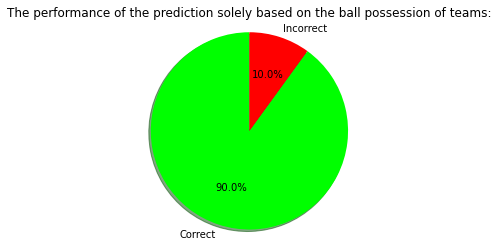

In [11]:
def PredPossesionBased():
    test=list(X['Ball possession'])
    test.sort()
    return [True if TeamResult in test[-7:] else False for TeamResult in X['Ball possession']]
    
EvaluatePreds(Y,PredPossesionBased(),'The performance of the prediction solely based on the ball possession of teams:')

#### Algorithm 2: Baseline - Random Guesswork

[10900000, 9100000]


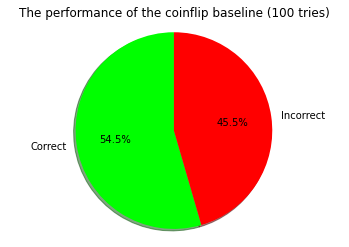

In [14]:
def PredRandom():
    result=[True]*7+[False]*13
    random.shuffle(result)
    return result
        
EvaluatePreds(list(np.array([x.values for x in [Y]*1000000]).flatten()),[y for y in PredRandom() for x in range(1000000)],'The performance of the coinflip baseline (100 tries)')

# Week 4

#### Test/Train split improved

#### Evaluate scores

#### Fix time duration to amount of seconds

#### Algorithm 3: linear SVC

[98, 102]


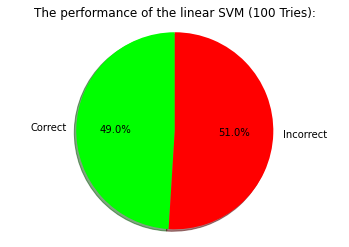

Wall time: 42min 31s


In [15]:
%%time
warnings.filterwarnings('ignore')

# fill NaNs with the median of the column
# the reason I used dfEverything and not X_train is because a column could be empty in X_train but not in dfEverything because of the test/train split.
# If a column in X_train is empty we couldnt use the median for it

y_pred=[]
Coefs=[]
sfs=[]

for train_index, test_index in RepeatedKFold(n_splits=4, n_repeats=10,random_state=1960).split(X.fillna(dfEverything.median())):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = Y.loc[train_index], Y.loc[test_index]
        linearSVM = LinearSVC(random_state=1960).fit(X_train.fillna(X.median()),y_train)
        a=SequentialFeatureSelector(linearSVM, n_features_to_select=5)
        b=a.fit(X_train.fillna(dfEverything.median()),y_train)
        featureBoolList=b.get_support()
        sfs.append(list(X_train.columns[list(compress(range(len(featureBoolList)), featureBoolList))]))
        Coefs.append(linearSVM.coef_[0])
        y_pred.append(list(linearSVM.predict(X_test.fillna(dfEverything.median()))))
        
        
y_pred=[item for sublist in y_pred for item in sublist] 
EvaluatePreds([item for sublist in ([Y]*100) for item in sublist],y_pred,"The performance of the linear SVM (100 Tries):")

#### Feature importance according to SVC

In [40]:
%%time

def fillToProperLengths(pos,neg,topX):
    #     the dataframe cant be created if the columns are of varying sizes
    
#     if the list is empty just create empty cells
    if not pos:
        pos=['No possitively correlating feature was found in the top '+str(topX)]+[np.nan]*(topX-1)
    else:
        for element in pos:

            if len(pos) !=topX:
                pos.append(np.nan)
            else:break
    if not neg:
        neg=['No negatively correlating feature was found in the top '+str(topX)]+[np.nan]*(topX-1)
    else:
        for element in neg:
            if len(neg) !=topX:
                neg.append(np.nan)
            else:break
    return {'pos':pos,'neg':neg}
    
def ShowPreds(coefs,result,topX=5):
    pos=[]
    neg=[]
    for i in range(topX):
        currentFeatureNumbered=list(enumerate(X_train.columns))[sorted([(x[0],abs(x[1])) for x in coefs],reverse=True, key=lambda tup: tup[1])[i][0]]
        if coefs[currentFeatureNumbered[0]][1]>0:
            
            pos.append(currentFeatureNumbered[1]+" ("+str("{:f}".format(coefs[currentFeatureNumbered[0]][1]))[:7]+")")

    for i in range(topX):
        currentFeatureNumbered=list(enumerate(X_train.columns))[sorted([(x[0],abs(x[1])) for x in coefs],reverse=True, key=lambda tup: tup[1])[i][0]]
        if coefs[currentFeatureNumbered[0]][1]<0:
            neg.append(currentFeatureNumbered[1]+" ("+str("{:f}".format(coefs[currentFeatureNumbered[0]][1]))[:8]+")")
    lists=fillToProperLengths(pos,neg,topX)
    winFeatures=pd.DataFrame(data={"These features contribute positively:":lists["pos"],"These features contribute negatively:":lists["neg"]}).fillna('')
    winFeatures.name="Most important features to predict a "+result+" :"
    print(winFeatures.name)
    display(winFeatures.style.hide_index())

Wall time: 78.1 ms
Parser   : 560 ms


In [17]:
def MeanForPosition(lst):
    return [mean(x for x in t if x != -1) for t in zip_longest(*lst, fillvalue=-1)]

ShowPreds([i[0] for i in zip(enumerate(MeanForPosition(Coefs)))],'top 7 finish')

top 7 finish
Most important features to predict a top 7 finish :


These features contribute positively:,These features contribute negatively:
Territorial supremacy (8.02657),Territorial supremacy in attack (avversari) (-8.14509)
Territorial supremacy in attack (3.99634),Balls played in attack area (avversari) (-3.62223)
,Balls won back (-3.32086)
,
,


[117, 83]


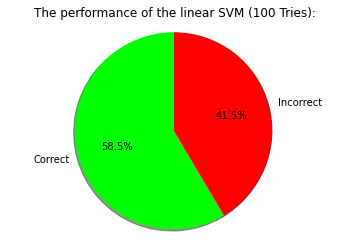

top 7 finish
Most important features to predict a top 7 finish :


These features contribute positively:,These features contribute negatively:
Average M Goal chances of all players (1.01814),Average Age of all players (-0.20026)
Average Acrobatic shots from a play of all players (0.02786),Average Acrobatic shots from a set play of all players (-0.15217)
Acrobatic shots (0.01759),
,
,


Wall time: 1.2 s


In [18]:
%%time
Flattenedsfs= [item for sublist in sfs for item in sublist]
SFSFeatures=[word for word, word_count in Counter(Flattenedsfs).most_common(5)]

y_pred=[]
Coefs=[]
for train_index, test_index in RepeatedKFold(n_splits=4, n_repeats=10,random_state=1960).split(X.fillna(dfEverything.median())):
        X_train, X_test = X[SFSFeatures].loc[train_index], X[SFSFeatures].loc[test_index]
        y_train, y_test = Y.loc[train_index], Y.loc[test_index]
        linearSVM = LinearSVC(random_state=1960).fit(X_train.fillna(dfEverything.median()),y_train)
        Coefs.append(linearSVM.coef_[0])
        y_pred.append(list(linearSVM.predict(X_test.fillna(dfEverything.median()))))
y_pred=[item for sublist in y_pred for item in sublist] 
EvaluatePreds([item for sublist in ([Y]*100) for item in sublist],y_pred,"The performance of the linear SVM (100 Tries):")
ShowPreds([i[0] for i in zip(enumerate(MeanForPosition(Coefs)))],'top 7 finish')

# Week 4
#### Random Forest

test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
[109, 91]


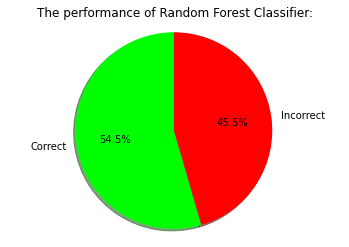

[(0, 0.0), (1, 0.0), (2, 0.0), (3, 0.00025), (4, 0.0), (5, 0.0), (6, 0.001755050505050505), (7, 0.002010204081632653), (8, 0.0007551020408163266), (9, 0.0002551020408163265), (10, 0.00025), (11, 0.0017525252525252527), (12, 0.0017601525458668316), (13, 0.0005), (14, 0.0), (15, 0.0), (16, 0.0007550505050505051), (17, 0.00025), (18, 0.0), (19, 0.0003195732838589981), (20, 0.002007627293341579), (21, 0.0005051020408163266), (22, 0.0015025252525252527), (23, 0.0), (24, 0.003272881880024737), (25, 0.0027678313749742323), (26, 0.0005), (27, 0.0), (28, 0.001007627293341579), (29, 0.0012525252525252527), (30, 0.0030152545866831584), (31, 0.001007627293341579), (32, 0.0002551020408163265), (33, 0.002515203050917337), (34, 0.0005), (35, 0.0032575757575757577), (36, 0.0), (37, 0.0), (38, 0.0007551020408163266), (39, 0.0), (40, 0.0), (41, 0.0), (42, 0.0), (43, 0.0), (44, 0.0), (45, 0.0), (46, 0.0), (47, 0.0), (48, 0.0), (49, 0.0), (50, 0.0), (51, 0.00025), (52, 0.0), (53, 0.0005), (54, 0.00025), (

Most important features to predict a top 7 finish :


These features contribute positively:,These features contribute negatively:
Lost ball poss. in defensive area (0.00653),No negatively correlating feature was found in the top 5
Average Shots from left side corner of all players (0.00633),
M Balls played in penalty area (0.00602),
Goal posts hit (0.00578),
Average M Goal chances.2 of all players (0.00576),


Wall time: 2d 17h 18min


In [19]:
%%time
Coefs=[]
y_pred=[]
sfs=[]
for train_index, test_index in RepeatedKFold(n_splits=4, n_repeats=10,random_state=1960).split(X.fillna(dfEverything.median())):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = Y.loc[train_index], Y.loc[test_index]
        clf = RandomForestClassifier(random_state=1960).fit(X_train.fillna(dfEverything.median()),y_train)
        test1=SequentialFeatureSelector(clf, n_features_to_select=5)
        featureBoolList=test1.fit(X_train.fillna(dfEverything.median()),y_train).get_support()
        sfs.append(list(X_train.columns[list(compress(range(len(featureBoolList)), featureBoolList))]))        
        Coefs.append(clf.feature_importances_)
        y_pred.append(clf.predict(X_test.fillna(dfEverything.median())))
        print('test')
y_pred=[item for sublist in y_pred for item in sublist]  
EvaluatePreds([item for sublist in ([Y]*100) for item in sublist],y_pred,"The performance of Random Forest Classifier:")
print([i[0] for i in zip(enumerate(MeanForPosition(Coefs)))])

ShowPreds([i[0] for i in zip(enumerate(MeanForPosition(Coefs)))],'top 7 finish')

[112, 88]


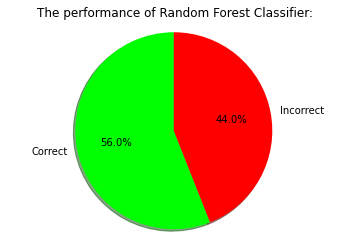

top 7 finish
Most important features to predict a top 7 finish :


These features contribute positively:,These features contribute negatively:
Accelerations (0.28877),No negatively correlating feature was found in the top 5
Acrobatic shots (0.24893),
Anticipations (0.17744),
Acrobatic shots from a set play (0.14854),
Acrobatic shots from a play (0.13628),


In [20]:
Coefs=[]
y_pred=[]
Flattenedsfs= [item for sublist in sfs for item in sublist]
SFSFeatures=[word for word, word_count in Counter(Flattenedsfs).most_common(5)]

for train_index, test_index in RepeatedKFold(n_splits=4, n_repeats=10,random_state=1).split(X.fillna(dfEverything.median())):
        X_train, X_test = X[SFSFeatures].loc[train_index], X[SFSFeatures].loc[test_index]
        y_train, y_test = Y.loc[train_index], Y.loc[test_index]
        clf = RandomForestClassifier(random_state=1960).fit(X_train.fillna(dfEverything.median()),y_train)
        Coefs.append(clf.feature_importances_)
        y_pred.append(clf.predict(X_test.fillna(dfEverything.median())))
y_pred=[item for sublist in y_pred for item in sublist]  
EvaluatePreds([item for sublist in ([Y]*100) for item in sublist],y_pred,"The performance of Random Forest Classifier:")
ShowPreds([i[0] for i in zip(enumerate(MeanForPosition(Coefs)))],'top 7 finish')

# Week 5

#### Gaussian Process Classifier

[130, 70]


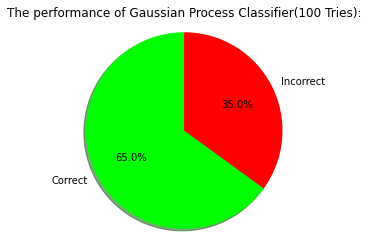

top 7 finish
Most important features to predict a top 7 finish :


These features contribute positively:,These features contribute negatively:
Attempted passes (0.31333),No negatively correlating feature was found in the top 5
Attempted passes in opponent midfield (0.31333),
Ball possession (0.31333),
Balls played (0.31333),
Balls played in attack area (avversari) (0.31333),


Wall time: 1h 32min 42s


In [21]:
%%time
warnings.filterwarnings('ignore')
y_pred=[]
Coefs=[]
sfs=[]

for train_index, test_index in RepeatedKFold(n_splits=4, n_repeats=10,random_state=1960).split(X.fillna(dfEverything.median())):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = Y.loc[train_index], Y.loc[test_index]
        gpc = GaussianProcessClassifier(multi_class="one_vs_one",random_state=1960).fit(X_train.fillna(dfEverything.median()),y_train)
        featureBoolList=SequentialFeatureSelector(gpc, n_features_to_select=5).fit(X_train.fillna(dfEverything.median()),y_train).get_support()
        sfs.append(list(X_train.columns[list(compress(range(len(featureBoolList)), featureBoolList))]))
        y_pred.append(gpc.predict(X_test.fillna(dfEverything.median())))
y_pred=[item for sublist in y_pred for item in sublist]
EvaluatePreds([item for sublist in ([Y]*100) for item in sublist],y_pred,"The performance of Gaussian Process Classifier(100 Tries):")

result = permutation_importance(gpc, X_train.fillna(dfEverything.median()), y_train, n_repeats=10)

ShowPreds([i[0] for i in zip(enumerate(result.importances_mean))],'top 7 finish')

[103, 97]


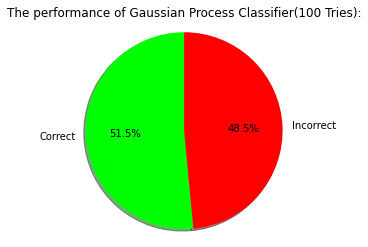

0      True
1     False
2     False
3     False
4     False
5     False
6     False
7      True
8      True
9      True
10    False
11     True
12     True
13    False
14     True
15    False
16    False
17    False
18    False
19    False
dtype: bool


TypeError: 'str' object cannot be interpreted as an integer

In [23]:

Flattenedsfs= [item for sublist in sfs for item in sublist]
SFSFeatures=[word for word, word_count in Counter(Flattenedsfs).most_common(5)]

y_pred=[]
Coefs=[]

for train_index, test_index in RepeatedKFold(n_splits=4, n_repeats=10,random_state=1960).split(X.fillna(dfEverything.median())):
        X_train, X_test = X[SFSFeatures].loc[train_index], X[SFSFeatures].loc[test_index]
        y_train, y_test = Y.loc[train_index], Y.loc[test_index]
        gpc = GaussianProcessClassifier(multi_class="one_vs_one",random_state=1960).fit(X_train.fillna(dfEverything.median()),y_train)
        featureBoolList=SequentialFeatureSelector(gpc, n_features_to_select=4).fit(X_train.fillna(dfEverything.median()),y_train).get_support()
        y_pred.append(gpc.predict(X_test.fillna(dfEverything.median())))
y_pred=[item for sublist in y_pred for item in sublist]
EvaluatePreds([item for sublist in ([Y]*100) for item in sublist],y_pred,"The performance of Gaussian Process Classifier(100 Tries):")

result = permutation_importance(gpc, X_train.fillna(dfEverything.median()), y_train, n_repeats=10)

ShowPreds([i[0] for i in zip(enumerate(result.importances_mean))],Y,'top 7 finish')

# Week 6 & 7

2 hypotheses: Attacking and defensive

In [24]:
hypAttack=[("Fouls suffered in attack area","Fouls suffered in attack"),('Received passes in attack',"Passes received in attack"),('Ball possession',"Ball possesion")]
hypDefence=[('Shots against',"Shots suffered"),('Ball possession',"Ball possesion"),("Total goals against from set play","Total goals conceded on set pieces"),("Substitutes in","Subs in"),("Interceptions","Interceptions")]
hypAttackColumns=[x[0] for x in hypAttack]
hypDefenceColumns=[x[0] for x in hypDefence]
XAttack=dfEverything[hypAttackColumns]
XDefence=dfEverything[hypDefenceColumns]

lineair svc

[111, 89]


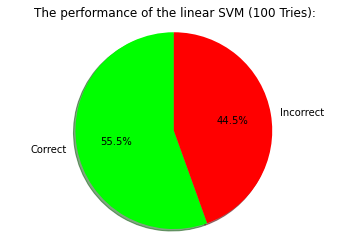

[102, 98]


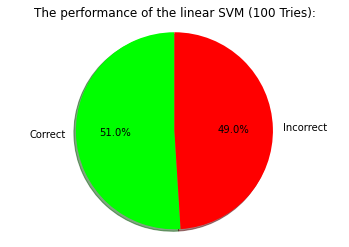

In [25]:
# attack
y_pred=[]
Coefs=[]
for train_index, test_index in RepeatedKFold(n_splits=4, n_repeats=10,random_state=1960).split(X.fillna(dfEverything.median())):
        X_train, X_test = XAttack.loc[train_index], XAttack.loc[test_index]
        y_train, y_test = Y.loc[train_index], Y.loc[test_index]
        linearSVM = LinearSVC(random_state=1960).fit(X_train.fillna(dfEverything.median()),y_train)
        Coefs.append(linearSVM.coef_[0])
        y_pred.append(list(linearSVM.predict(X_test.fillna(dfEverything.median()))))
y_pred=[item for sublist in y_pred for item in sublist] 
EvaluatePreds([item for sublist in ([Y]*100) for item in sublist],y_pred,"The performance of the linear SVM (100 Tries):")

# defence
y_pred=[]
Coefs=[]
for train_index, test_index in RepeatedKFold(n_splits=4, n_repeats=10,random_state=1960).split(X.fillna(dfEverything.median())):
        X_train, X_test = XDefence.loc[train_index], XDefence.loc[test_index]
        y_train, y_test = Y.loc[train_index], Y.loc[test_index]
        linearSVM = LinearSVC(random_state=1960).fit(X_train.fillna(dfEverything.median()),y_train)
        Coefs.append(linearSVM.coef_[0])
        y_pred.append(list(linearSVM.predict(X_test.fillna(dfEverything.median()))))
y_pred=[item for sublist in y_pred for item in sublist] 
EvaluatePreds([item for sublist in ([Y]*100) for item in sublist],y_pred,"The performance of the linear SVM (100 Tries):")

random forest

top 7 finish
Most important features to predict a top 7 finish :


These features contribute positively:,These features contribute negatively:
Ball possession (0.33404),No negatively correlating feature was found in the top 5
Shots against (0.30498),
Total goals against from set play (0.19526),
Interceptions (0.11012),
Substitutes in (0.05558),


[109, 91]


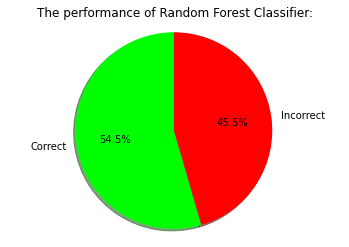

In [36]:
# # attack
Coefs=[]
y_pred=[]
sfs=[]
for train_index, test_index in RepeatedKFold(n_splits=4, n_repeats=10,random_state=1960).split(X.fillna(dfEverything.median())):
        X_train, X_test = XAttack.loc[train_index], XAttack.loc[test_index]
        y_train, y_test = Y.loc[train_index], Y.loc[test_index]
        clf = RandomForestClassifier(random_state=1960).fit(X_train.fillna(dfEverything.median()),y_train)
        Coefs.append(clf.feature_importances_)
        y_pred.append(clf.predict(X_test.fillna(dfEverything.median())))
y_pred=[item for sublist in y_pred for item in sublist]  
EvaluatePreds([item for sublist in ([Y]*100) for item in sublist],y_pred,"The performance of Random Forest Classifier:")
ShowPreds([i[0] for i in zip(enumerate(MeanForPosition(Coefs)))],'top 7 finish')

# defence
Coefs=[]
y_pred=[]
sfs=[]
for train_index, test_index in RepeatedKFold(n_splits=4, n_repeats=10,random_state=1960).split(X.fillna(dfEverything.median())):
        X_train, X_test = XDefence.loc[train_index], XDefence.loc[test_index]
        y_train, y_test = Y.loc[train_index], Y.loc[test_index]
        clf = RandomForestClassifier(random_state=1960).fit(X_train.fillna(dfEverything.median()),y_train)
        Coefs.append(clf.feature_importances_)
        y_pred.append(clf.predict(X_test.fillna(dfEverything.median())))
y_pred=[item for sublist in y_pred for item in sublist] 

ShowPreds([i[0] for i in zip(enumerate(MeanForPosition(Coefs)))],'top 7 finish')
EvaluatePreds([item for sublist in ([Y]*100) for item in sublist],y_pred,"The performance of Random Forest Classifier:")


Gaussian

[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False

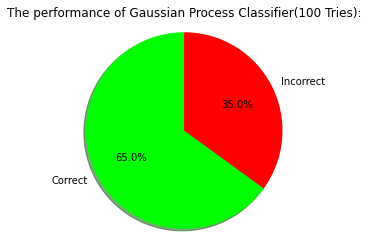

Most important features to predict a top 7 finish :


These features contribute positively:,These features contribute negatively:
Ball possession (0.40000),No negatively correlating feature was found in the top 5
Interceptions (0.36666),
Shots against (0.26000),
,
,


In [42]:
# attack
y_pred=[]
Coefs=[]
sfs=[]
for train_index, test_index in RepeatedKFold(n_splits=4, n_repeats=10,random_state=1960).split(X.fillna(dfEverything.median())):
        X_train, X_test = XAttack.loc[train_index], XAttack.loc[test_index]
        y_train, y_test = Y.loc[train_index], Y.loc[test_index]
        gpc = GaussianProcessClassifier(multi_class="one_vs_one",random_state=1960).fit(X_train.fillna(dfEverything.median()),y_train)
        featureBoolList=SequentialFeatureSelector(gpc).fit(X_train.fillna(dfEverything.median()),y_train).get_support()
        sfs.append(list(X_train.columns[list(compress(range(len(featureBoolList)), featureBoolList))]))
        y_pred.append(gpc.predict(X_test.fillna(dfEverything.median())))
y_pred=[item for sublist in y_pred for item in sublist]
EvaluatePreds([item for sublist in ([Y]*100) for item in sublist],y_pred,"The performance of Gaussian Process Classifier(100 Tries):")

result = permutation_importance(gpc, X_train.fillna(dfEverything.median()), y_train, n_repeats=10)

ShowPreds([i[0] for i in zip(enumerate(result.importances_mean))],'top 7 finish')

# defence
y_pred=[]
Coefs=[]
sfs=[]
for train_index, test_index in RepeatedKFold(n_splits=4, n_repeats=10,random_state=1960).split(X.fillna(dfEverything.median())):
        X_train, X_test = XDefence.loc[train_index], XDefence.loc[test_index]
        y_train, y_test = Y.loc[train_index], Y.loc[test_index]
        gpc = GaussianProcessClassifier(multi_class="one_vs_one",random_state=1960).fit(X_train.fillna(dfEverything.median()),y_train)
        featureBoolList=SequentialFeatureSelector(gpc).fit(X_train.fillna(dfEverything.median()),y_train).get_support()
        sfs.append(list(X_train.columns[list(compress(range(len(featureBoolList)), featureBoolList))]))
        y_pred.append(gpc.predict(X_test.fillna(dfEverything.median())))
y_pred=[item for sublist in y_pred for item in sublist]
print(y_pred)
EvaluatePreds([item for sublist in ([Y]*100) for item in sublist],y_pred,"The performance of Gaussian Process Classifier(100 Tries):")

result = permutation_importance(gpc, X_train.fillna(dfEverything.median()), y_train, n_repeats=10)

ShowPreds([i[0] for i in zip(enumerate(result.importances_mean))],'top 7 finish')